In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Vérifier si GPU est disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 13.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]


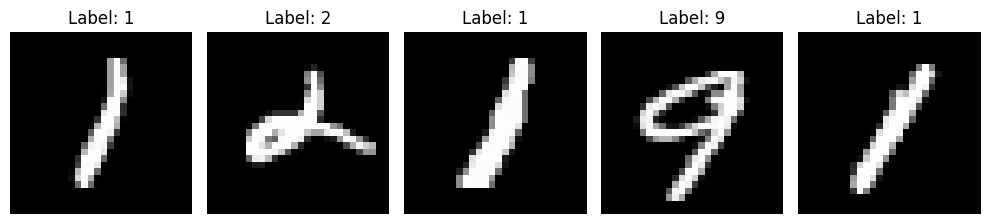

In [4]:
# Définir les transformations pour les données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Moyenne et écart-type du dataset MNIST
])

# Chargement des données MNIST directement depuis torchvision
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Création des dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualisation de quelques exemples
def show_examples(dataloader, n=5):
    examples = iter(dataloader)
    images, labels = next(examples)
    fig = plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(train_loader)

In [12]:
# Définition d'une architecture CNN simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Première couche de convolution
        # entrée: 1x28x28, sortie: 32x26x26 (après conv)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # Après pooling: 32x13x13
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Deuxième couche de convolution
        # entrée: 32x13x13, sortie: 64x11x11 (après conv)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # Après pooling: 64x5x5
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Couche fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Régularisation
        self.fc2 = nn.Linear(128, 10)  # 10 classes pour MNIST

    def forward(self, x):
        # Couches de convolution
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Aplatir pour passer aux couches fully connected
        x = x.view(-1, 64 * 5 * 5)

        # Couches fully connected
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Création du modèle
cnn_model = SimpleCNN().to(device)
print(cnn_model)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)  # weight_decay pour la régularisation L2

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# Fonction d'entraînement
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []
    train_accs = []
    train_times = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for i, data in enumerate(dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Réinitialisation des gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistiques
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        train_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')

    return train_losses, train_accs, train_times

# Fonction d'évaluation
def evaluate_model(model, dataloader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collecte des prédictions et des étiquettes pour le calcul du F1-score
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    # Calcul du F1-score (macro pour moyenne sur toutes les classes)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}')

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss, accuracy, f1, cm


Entraînement du modèle CNN:
Epoch [1/5], Step [100/938], Loss: 0.4037
Epoch [1/5], Step [200/938], Loss: 0.2289
Epoch [1/5], Step [300/938], Loss: 0.1887
Epoch [1/5], Step [400/938], Loss: 0.1668
Epoch [1/5], Step [500/938], Loss: 0.1714
Epoch [1/5], Step [600/938], Loss: 0.1258
Epoch [1/5], Step [700/938], Loss: 0.0613
Epoch [1/5], Step [800/938], Loss: 0.2026
Epoch [1/5], Step [900/938], Loss: 0.1269
Epoch [1/5], Loss: 0.2145, Accuracy: 93.52%, Time: 16.08s
Epoch [2/5], Step [100/938], Loss: 0.0333
Epoch [2/5], Step [200/938], Loss: 0.0931
Epoch [2/5], Step [300/938], Loss: 0.0199
Epoch [2/5], Step [400/938], Loss: 0.1190
Epoch [2/5], Step [500/938], Loss: 0.0616
Epoch [2/5], Step [600/938], Loss: 0.1684
Epoch [2/5], Step [700/938], Loss: 0.0128
Epoch [2/5], Step [800/938], Loss: 0.0611
Epoch [2/5], Step [900/938], Loss: 0.0673
Epoch [2/5], Loss: 0.0829, Accuracy: 97.61%, Time: 13.58s
Epoch [3/5], Step [100/938], Loss: 0.0953
Epoch [3/5], Step [200/938], Loss: 0.0184
Epoch [3/5], St

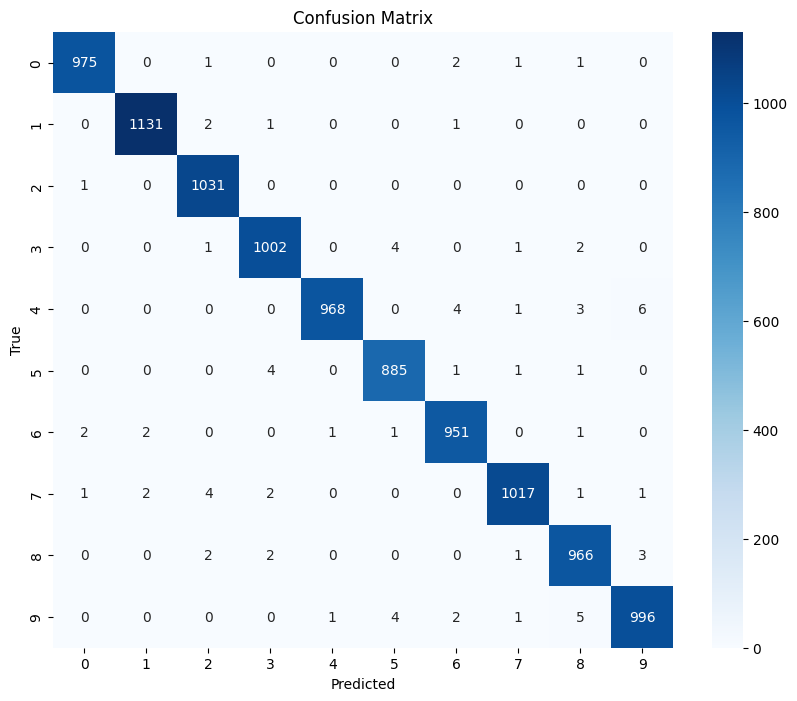

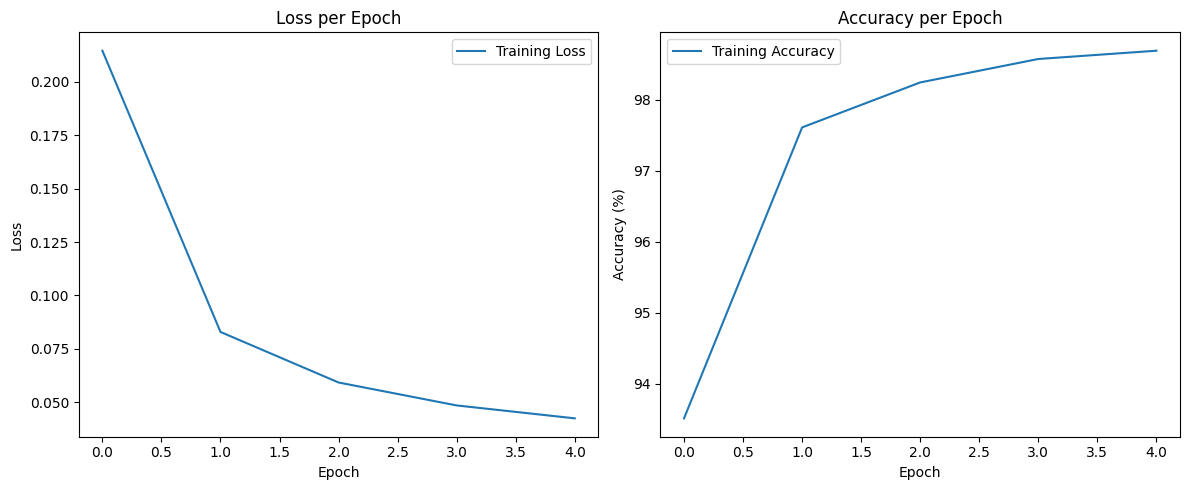

Modèle CNN sauvegardé avec succès!


In [7]:
# Entraînement du modèle CNN
print("\nEntraînement du modèle CNN:")
cnn_losses, cnn_accs, cnn_times = train_model(cnn_model, train_loader, criterion, optimizer, epochs=5)

# Évaluation du modèle CNN
print("\nÉvaluation du modèle CNN:")
cnn_test_loss, cnn_accuracy, cnn_f1, cnn_cm = evaluate_model(cnn_model, test_loader, criterion)

# Visualisation de la courbe d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_losses, label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_accs, label='Training Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Sauvegarde du modèle CNN
torch.save(cnn_model.state_dict(), 'cnn_mnist_model.pth')
print("Modèle CNN sauvegardé avec succès!")

In [8]:
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Pour adapter Faster R-CNN à MNIST, nous devons d'abord transformer
# nos images en RGB (3 canaux)
transform_rcnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Répéter le canal en gris pour obtenir 3 canaux
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

train_dataset_rcnn = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_rcnn)
test_dataset_rcnn = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_rcnn)

# Adapter le dataset pour Faster R-CNN
class MNISTRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Créer une boîte englobante pour l'image entière
        boxes = torch.tensor([[0, 0, 28, 28]], dtype=torch.float32)
        # Étiquettes pour la détection d'objets (ici, c'est simplement le label MNIST + 1)
        # Le +1 est nécessaire car 0 est réservé pour le fond en détection d'objets
        labels = torch.tensor([label + 1], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = torch.tensor([28*28], dtype=torch.float32)
        target["iscrowd"] = torch.tensor([0], dtype=torch.int64)

        return image, target

    def __len__(self):
        return len(self.dataset)

# Créer des datasets adaptés pour Faster R-CNN
train_dataset_rcnn = MNISTRCNNDataset(train_dataset_rcnn)
test_dataset_rcnn = MNISTRCNNDataset(test_dataset_rcnn)

# Fonction pour collate_fn personnalisée pour Faster R-CNN
def collate_fn(batch):
    return tuple(zip(*batch))

# Création des dataloaders pour Faster R-CNN (batch size plus petit à cause de la mémoire GPU)
batch_size_rcnn = 8
train_loader_rcnn = DataLoader(train_dataset_rcnn, batch_size=batch_size_rcnn, shuffle=True, collate_fn=collate_fn)
test_loader_rcnn = DataLoader(test_dataset_rcnn, batch_size=batch_size_rcnn, shuffle=False, collate_fn=collate_fn)

# Création du modèle Faster R-CNN
def get_faster_rcnn_model(num_classes=11):  # 10 classes MNIST + 1 pour le fond
    # Chargement d'un modèle pré-entraîné
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Obtenir le nombre de caractéristiques d'entrée pour le prédicteur
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Remplacer le prédicteur par un nouveau avec le bon nombre de classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Création du modèle Faster R-CNN
rcnn_model = get_faster_rcnn_model().to(device)
print(rcnn_model)

# Définition de l'optimiseur pour Faster R-CNN
optimizer_rcnn = optim.SGD(rcnn_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 163MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# Fonction d'entraînement pour Faster R-CNN avec moins d'époques et reporting plus espacé
def train_rcnn_model(model, dataloader, optimizer, epochs=2):  # Réduit à 2 époques au lieu de 5
    model.train()
    train_losses = []
    train_times = []

    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        # Option 1: Utiliser un sous-ensemble du dataloader
        subset_size = len(dataloader) // 2  # Utiliser seulement la moitié des données

        for i, (images, targets) in enumerate(dataloader):
            # Option 2: Sortir de la boucle après un certain nombre d'étapes
            if i >= subset_size:
                break

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Réinitialisation des gradients
            optimizer.zero_grad()

            # Forward
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward + optimize
            losses.backward()
            optimizer.step()

            # Statistiques
            running_loss += losses.item()

            # Rapport moins fréquent (toutes les 100 étapes au lieu de 50)
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{subset_size}], Loss: {losses.item():.4f}')

        epoch_time = time.time() - start_time
        epoch_loss = running_loss / (subset_size or 1)  # Éviter division par zéro

        train_losses.append(epoch_loss)
        train_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s')

    return train_losses, train_times

# La fonction d'évaluation reste inchangée
def evaluate_rcnn_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)

            # Obtenir les prédictions
            outputs = model(images)

            # Extraire les labels réels
            true_labels = [target['labels'][0].item() - 1 for target in targets]  # -1 pour revenir aux labels MNIST originaux

            # Extraire les prédictions (classe avec le score le plus élevé)
            for output in outputs:
                if len(output['labels']) > 0:  # S'assurer qu'une détection a été faite
                    # Prendre l'étiquette de la boîte avec le score le plus élevé
                    best_idx = output['scores'].argmax().item()
                    pred_label = output['labels'][best_idx].item() - 1  # -1 pour revenir aux labels MNIST originaux
                else:
                    # Si aucune détection, prédire 0 par défaut
                    pred_label = 0
                all_preds.append(pred_label)

            all_labels.extend(true_labels)

    # Calcul des métriques
    accuracy = 100 * accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}')

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, f1, cm

In [ ]:
# Entraînement du modèle Faster R-CNN
print("\nEntraînement du modèle Faster R-CNN:")
rcnn_losses, rcnn_times = train_rcnn_model(rcnn_model, train_loader_rcnn, optimizer_rcnn, epochs=3)

# Évaluation du modèle Faster R-CNN
print("\nÉvaluation du modèle Faster R-CNN:")
rcnn_accuracy, rcnn_f1, rcnn_cm = evaluate_rcnn_model(rcnn_model, test_loader_rcnn)

# Sauvegarde du modèle Faster R-CNN
torch.save(rcnn_model.state_dict(), 'rcnn_mnist_model.pth')
print("Modèle Faster R-CNN sauvegardé avec succès!")


Entraînement du modèle Faster R-CNN:
Epoch [1/3], Step [100/3750], Loss: 0.1129
Epoch [1/3], Step [200/3750], Loss: 0.0710
Epoch [1/3], Step [300/3750], Loss: 0.0513
Epoch [1/3], Step [400/3750], Loss: 0.0344
Epoch [1/3], Step [500/3750], Loss: 0.0274
Epoch [1/3], Step [600/3750], Loss: 0.0238
Epoch [1/3], Step [700/3750], Loss: 0.0256
Epoch [1/3], Step [800/3750], Loss: 0.0219
Epoch [1/3], Step [900/3750], Loss: 0.0202
Epoch [1/3], Step [1000/3750], Loss: 0.0198
Epoch [1/3], Step [1100/3750], Loss: 0.0173
Epoch [1/3], Step [1200/3750], Loss: 0.0160
Epoch [1/3], Step [1300/3750], Loss: 0.0197
Epoch [1/3], Step [1400/3750], Loss: 0.0191
Epoch [1/3], Step [1500/3750], Loss: 0.0141
Epoch [1/3], Step [1600/3750], Loss: 0.0120
Epoch [1/3], Step [1700/3750], Loss: 0.0097
Epoch [1/3], Step [1800/3750], Loss: 0.0173
Epoch [1/3], Step [1900/3750], Loss: 0.0100
Epoch [1/3], Step [2000/3750], Loss: 0.0177
Epoch [1/3], Step [2100/3750], Loss: 0.0097
Epoch [1/3], Step [2200/3750], Loss: 0.0096
Epo

In [6]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# Vérifier si GPU est disponible et définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Fonction pour créer un modèle VGG16 adapté à MNIST
def get_vgg16_model(num_classes=10):
    model = models.vgg16(pretrained=True)

    # Modifier la première couche pour accepter des images en niveaux de gris (1 canal)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

    # Modifier la dernière couche fully connected pour le nombre de classes MNIST
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)

    return model

# Fonction pour créer un modèle AlexNet adapté à MNIST
def get_alexnet_model(num_classes=10):
    model = models.alexnet(pretrained=True)

    # Modifier la première couche pour accepter des images en niveaux de gris (1 canal)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

    # Modifier la dernière couche fully connected pour le nombre de classes MNIST
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)

    return model

# Création des modèles pré-entraînés
vgg16_model = get_vgg16_model().to(device)
alexnet_model = get_alexnet_model().to(device)

# Redimensionner les images MNIST pour les modèles pré-entraînés
# VGG16 et AlexNet attendent des images plus grandes
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_pretrained = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_pretrained)
test_dataset_pretrained = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_pretrained)

train_loader_pretrained = DataLoader(train_dataset_pretrained, batch_size=32, shuffle=True)
test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=32, shuffle=False)

# Définition des optimiseurs pour les modèles pré-entraînés
optimizer_vgg = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)
optimizer_alexnet = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 51.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.61MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.35MB/s]


In [10]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    losses = []
    accuracies = []
    training_times = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Réinitialisation des gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass et optimisation
            loss.backward()
            optimizer.step()

            # Statistiques
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Afficher la progression
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

        # Calculer les métriques pour cette époque
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100.0 * correct / total
        epoch_time = time.time() - start_time

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        training_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')

    return losses, accuracies, training_times

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistiques
            total_loss += loss.item()
            _, predicted = outputs.max(1)

            # Collecter les prédictions et les cibles
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calcul des métriques
    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    # Matrice de confusion
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}')

    return avg_loss, accuracy, f1, cm

In [ ]:
# Entraînement du modèle VGG16
print("\nEntraînement du modèle VGG16:")
vgg_losses, vgg_accs, vgg_times = train_model(vgg16_model, train_loader_pretrained, criterion, optimizer_vgg, epochs=3)

# Évaluation du modèle VGG16
print("\nÉvaluation du modèle VGG16:")
vgg_test_loss, vgg_accuracy, vgg_f1, vgg_cm = evaluate_model(vgg16_model, test_loader_pretrained, criterion)

# Entraînement du modèle AlexNet
print("\nEntraînement du modèle AlexNet:")
alexnet_losses, alexnet_accs, alexnet_times = train_model(alexnet_model, train_loader_pretrained, criterion, optimizer_alexnet, epochs=3)

# Évaluation du modèle AlexNet
print("\nÉvaluation du modèle AlexNet:")
alexnet_test_loss, alexnet_accuracy, alexnet_f1, alexnet_cm = evaluate_model(alexnet_model, test_loader_pretrained, criterion)

# Sauvegarde des modèles pré-entraînés
torch.save(vgg16_model.state_dict(), 'vgg16_mnist_model.pth')
torch.save(alexnet_model.state_dict(), 'alexnet_mnist_model.pth')
print("Modèles pré-entraînés sauvegardés avec succès!")


Entraînement du modèle VGG16:
